# Trabalho de Inteligência Artificial

## Construção de uma rede neural usando Rede neural convolucional

### Realizado por Gabriel Castro Fernandes

No trabalho realizado foi escolhido usar o dataset `Oregon Wildlife` que se encontra no Kaggle ([link do dataset](https://www.kaggle.com/virtualdvid/oregon-wildlife)). É um dataset com 20 classes de animais selvagens e com uma quantidade de imagens boa.

A base de imagens é dividida em pastas, onde cada uma contém uma espécie de animal. Logo, é preciso juntar esses dados de forma a se criar um dataset dividamente apropriado para uso na modelagem.

A criação do dataset poderia ser realizada de algumas maneiras: 
- Usando kernel do Kaggle;
- Baixar as imagens localmente;
- Subir no Google Drive e montar o drive;

No meu caso achei mais confortável usar localmente pois consegueria navegar entre as pastas e para essa etapa não teria impacto em tempo para construção do dataset.

Foi criado então uma classe python para poder realizar esse conversão. Nela foi usado a classe `cv2` proveniente da biblioteca openCV para a leitura das imagens, conversão de BGR para RGB (`BGR2RGB`) e diminuição de escala (`resize`) para 64x64. Após isso o conjunto de imagens lidas é convertido para um numpy array.

A conversão do set de imagens é importante por dois motivos:
- Divisão das imagens entre treino e teste, usando o método `train_test_split`, definindo uma taxa de 15% do set para a parte de teste.
- Criação dos arquivos HDF5 (explicado logo abaixo).

Os arquivos gerados (dataset.h5 e label.h5) possuem um tamanho relativamente pequeno comparado ao do set de imagens, sendo assim mais fácil de subir no Google Drive para usar juntamente com o Colab, visto que fazer a modelagem na máquina pessoal seria inviável pela falta de processamento e gpu. 


> [Código da classe de criação do dataset usado aqui](https://github.com/gabcastro/Unisinos-AI-CNNKaggleDataset/blob/master/modelling_dataset.py)



# Importação do dataset

O dataset usado foi criado através da junção de diversas imagens, onde foi criado numpy arrays para as imagens e para as labels, respectivamente. 

Por seguinte, foi usado a biblioteca h5py para criar arquivos HDF5¹ destes numpy arrays. 

Para realizar isso, criei uma classe a parte onde foi executada localmente. O fonte desta classe pode ser encontrada aqui: [modelagem do dataset](https://github.com/gabcastro/Unisinos-AI-CNNKaggleDataset/blob/master/modelling_dataset.py).

----

¹ **HDF5** é um modelo de dados que permite que seu conteúdo possa ser facilmente manipulado – mesmo quando o tamanho do dataset ultrapassa os gigabytes

In [1]:
import h5py

from google.colab import drive
drive.mount('/content/drive/')

h5f = h5py.File('/content/drive/My Drive/Colab Notebooks/dataset_64_rgb.h5','r')
X_train = h5f['X_train'][:]
X_test = h5f['X_test'][:]
h5f.close()    

h5f = h5py.File('/content/drive/My Drive/Colab Notebooks/labels_64_rgb.h5','r')
y_train = h5f['y_train'][:]
y_test = h5f['y_test'][:]
h5f.close()   

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import time
import sklearn
import urllib
import cv2

from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn import metrics
from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


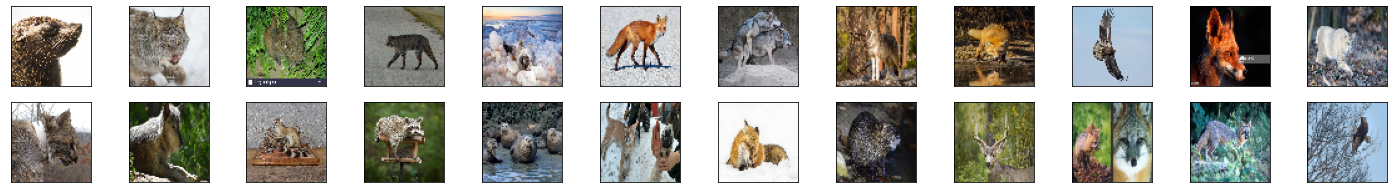

In [ ]:
fig = plt.figure(figsize=(25,5))
for i in range(24):
    ax = fig.add_subplot(3,12, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[i]))

# Plot functions

In [3]:
def plot_loss(hist_model):
    plt.plot(hist_model.history['loss'])
    plt.plot(hist_model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

def plot_accuracy(hist_model):
    plt.plot(hist_model.history['accuracy'])
    plt.plot(hist_model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Normalização

In [4]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Resumo dos conjuntos de dados

In [5]:
summary_shape = {}

summary_shape['X_train'] = X_train.shape
summary_shape['X_test'] = X_test.shape
summary_shape['y_train'] = y_train.shape
summary_shape['y_test'] = y_test.shape

pd.DataFrame(summary_shape.items(), columns=['In/Out', 'Total shape'])

,In/Out,Total shape
0,X_train,"(11860, 64, 64, 3)"
1,X_test,"(2094, 64, 64, 3)"
2,y_train,"(11860, 20)"
3,y_test,"(2094, 20)"


# Deep learning model(s)

Para a modelagem, comecei utilizando 6 camadas de convolução, e uma camada densa de 1024. Contudo, a modelagem não estava performando bem, então fui realizando algumas mudanças aumentando o número de camadas, porém isso se mostrou pior. Abaixo exemplifico mostrando dois testes realizados:

Camada       | Tamanho    | Dropout 
---------    | ---------  | --------
Conv2D       |  2x32      |   0.2
Conv2D       |  2x64      |   0.2
Conv2D       |  2x256     |   0.2
Dense        |  1x1024    |   0.5
\
Acurácia     |            |  0.68
Perda        |            |  1.11

\\

Camada       | Tamanho    | Dropout 
---------    | ---------  | --------
Conv2D       |  2x32      |   0.2
Conv2D       |  2x64      |   0.2
Conv2D       |  2x128     |   0.2
Conv2D       |  2x256     |   0.2
Dense        |  1x2048    |   0.5
\
Acurácia     |            |  0.44
Perda        |            |  1.70

\\
Algumas mudanças de dropouts também foram realizadas e mesma assim seguiram com uma performance ruim. Por este motivo comecei a seguir na linha contrária, diminuindo a quantidade de camadas, mas mantendo um tamanho alto delas.

\\

Camada       | Tamanho    | Dropout 
---------    | ---------  | --------
Conv2D       |  2x32      |   
Conv2D       |  1x256     |   0.2
Dense        |  1x1024    |   0.5
\
Acurácia     |            |  0.71
Perda        |            |  0.96
Lr           |            |  0.02

\\

Camada       | Tamanho    | Dropout 
---------    | ---------  | --------
Conv2D       |  2x32      |   
Conv2D       |  1x1024    |   0.3
Dense        |  1x2048    |   0.5
\
Acurácia     |            |  0.85
Perda        |            |  0.50
Lr           |            |  0.025

\\

Outro ponto importante foi a remoção do `Dropout` da primeira camada. Segundo algumas referencias, o dropout é bom para remoção do overfitting, contudo deve-se cuidar pois ele pode alterar o ganho performance no modelo. É importante ter certeza que o modelo está tendeciando a ter o overfitting, muitas vezes avaliado pelo tamanho da rede, treinos longos ou poucos dados.

Ainda sobre o modelo, temos o **SGD** (*stochastic gradient descent*), que é um algoritmo otimizador que estima o erro gradiente do estado atual no momento que está usando um dataset de treinamento, atualizando assim os pesos do modelo usando algoritmo de *backpropagation*.

Esses pesos, são referidos a uma taxa de aprendizado (*learning rate*). As taxas possuem um range de valores pequeno, que vai de 0.0 a 1.0.

A taxa controla o como o modelo vai se adaptar ao problema, se mais rápido ou lentamente. Taxas pequenas necessitam mais épocas para que ocorra atualização nos pesos. Diferente de taxas grandes onde o resultado é rápido e com poucas épocas.
Taxas que são muito grandes podem convergir rápido para um sub ótima solução. E taxas pequenas podem fazer o modelo ficar preso.

\\

No meu caso comecei usando a padrão de 0.01, contudo aumentei para 0.025 ao longo dos testes, onde vi uma melhora significativa no processo de aprendizagem.

In [6]:
def create_conv():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(1024, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    opt = SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

No método abaixo usei um *data augmentation* que seria um "aumento" das possibilidades de ver a imagem, só que em ângulos diferentes. Significa que conseguimos ter um número diverso de variações da imagem (rotação, ângulo, etc.). Permitindo assim a diminuir novamente a chance de existir overfitting, além de generalizar melhor no treinamento.

[Data augmentation](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)

In [7]:
def training(model, X_train, X_test, y_train, y_test):
    
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
    )
    datagen.fit(X_train)

    filepath="best_weights_conv.hdf5"

    checkpoint = ModelCheckpoint(
        filepath, 
        monitor='val_accuracy', 
        verbose=0, 
        save_best_only=True, 
        mode='max'
    )

    callbacks_list = [LearningRateScheduler(lr_schedule), checkpoint]

    history = model.fit_generator(
        datagen.flow(X_train, y_train, batch_size=32),
        steps_per_epoch=X_train.shape[0] // 32,
        epochs=60,
        validation_data=(X_test, y_test),
        callbacks=callbacks_list
    )

    return model, history 

In [8]:
def lr_schedule(epoch):
    lr = 0.01
    return lr*(0.1**int(epoch/10))

In [9]:
model = create_conv()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 1024)      295936    
_________________________________________________________________
activation_3 (Activation)    (None, 31, 31, 1024)     

In [10]:
model, history = training(model, X_train, X_test, y_train, y_test)

Epoch 1/60
370/370 [==============================] - 75s 202ms/step - loss: 2.7921 - accuracy: 0.1393 - val_loss: 2.5135 - val_accuracy: 0.2068
Epoch 2/60
  1/370 [..............................] - ETA: 1:05 - loss: 2.7024 - accuracy: 0.2188

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


370/370 [==============================] - 67s 181ms/step - loss: 2.5049 - accuracy: 0.2283 - val_loss: 2.3803 - val_accuracy: 0.2598
Epoch 3/60
370/370 [==============================] - 67s 181ms/step - loss: 2.3403 - accuracy: 0.2733 - val_loss: 2.2125 - val_accuracy: 0.3314
Epoch 4/60
370/370 [==============================] - 67s 181ms/step - loss: 2.1756 - accuracy: 0.3346 - val_loss: 1.9956 - val_accuracy: 0.3945
Epoch 5/60
370/370 [==============================] - 67s 180ms/step - loss: 2.0252 - accuracy: 0.3812 - val_loss: 1.8605 - val_accuracy: 0.4422
Epoch 6/60
370/370 [==============================] - 67s 181ms/step - loss: 1.8991 - accuracy: 0.4200 - val_loss: 1.6705 - val_accuracy: 0.4995
Epoch 7/60
370/370 [==============================] - 67s 180ms/step - loss: 1.7272 - accuracy: 0.4746 - val_loss: 1.5619 - val_accuracy: 0.5301
Epoch 8/60
370/370 [==============================] - 67s 181ms/step - loss: 1.6024 - accuracy: 0.5116 - val_loss: 1.4496 - val_accuracy: 0.5

# Resultados

Podemos ver que o resultado da acurácia ficou relativamente boa, na casa 86%, contudo, a perda poderia ser mais baixa, além de ela mostrar sinais de talvez um overfitting, se colocado mais épocas.

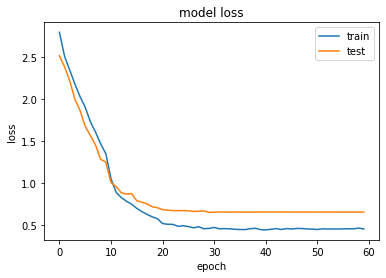

In [11]:
plot_loss(history)

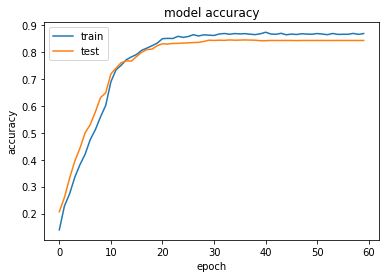

In [12]:
plot_accuracy(history)

In [13]:
dist = {
    k: tuple(d[k] for d in [dict(Counter(np.where(y_train==1)[1])), dict(Counter(np.where(y_test==1)[1]))]) for k in range(num_classes)
}

map_animals = {
    0: 'bald_eagle',
    1: 'black_bear',
    2: 'bobcat',
    3: 'canada_lynx',
    4: 'columbian_black-tailed_deer',
    5: 'cougar',
    6: 'coyote',
    7: 'deer',
    8: 'elk',
    9: 'gray_fox',
    10: 'gray_wolf',
    11: 'mountain_beaver',
    12: 'nutria',
    13: 'raccoon',
    14: 'raven',
    15: 'red_fox',
    16: 'ringtail',
    17: 'sea_lions',
    18: 'seals',
    19: 'virginia_opossum'
}

summ_train = {}
summ_test = {}

for k, v in sorted(dist.items(), key = lambda x:x[1][0], reverse=True):
    summ_train[map_animals[k]] = v[0]
    summ_test[map_animals[k]] = v[1]

df1 = pd.DataFrame(summ_train.items(), columns=['Class', 'Total train'])
df2 = pd.DataFrame(summ_test.values(), columns=['Total test'])

summary_num_data = pd.concat([df1, df2], axis=1, sort=False)

summary_num_data

,Class,Total train,Total test
0,red_fox,655,103
1,deer,653,110
2,columbian_black-tailed_deer,625,110
3,coyote,625,111
4,gray_wolf,622,108
5,raccoon,620,104
6,canada_lynx,618,98
7,sea_lions,618,106
8,bald_eagle,615,127
9,virginia_opossum,600,127


O número de imagens não é tão grande quanto o esperado após a separação em classes, e ainda a divisão entre treino e teste.

Mas abaixo conseguimos ver um report da precisão de cada classe:

In [15]:
y_pred = model.predict(X_test)
print('\n', 
    sklearn.metrics.classification_report(
        np.where(y_test > 0)[1], 
        np.argmax(y_pred, axis=1), 
        target_names=list(map_animals.values())), sep='')


                             precision    recall  f1-score   support

                 bald_eagle       0.89      0.91      0.90       127
                 black_bear       0.93      0.95      0.94       117
                     bobcat       0.71      0.86      0.78       110
                canada_lynx       0.81      0.81      0.81        98
columbian_black-tailed_deer       0.81      0.84      0.83       110
                     cougar       0.94      0.82      0.88       111
                     coyote       0.82      0.85      0.83       111
                       deer       0.73      0.82      0.77       110
                        elk       0.88      0.87      0.88        95
                   gray_fox       0.82      0.79      0.80        95
                  gray_wolf       0.81      0.84      0.83       108
            mountain_beaver       0.84      0.85      0.85        88
                     nutria       0.76      0.87      0.81        97
                    raccoon     

Outra análise interessante é a matriz de confusão, onde conseguimos ter uma noção de qual classe está mais precisa (com a acurácia mais alta) em relação as demais.

Logo, podemos notar que `bald_eagle`, `black_bear` e `virginia_opossum` são as mais perfomáticas.

Em contraponto, temos o `ringtail` como pior precisão.

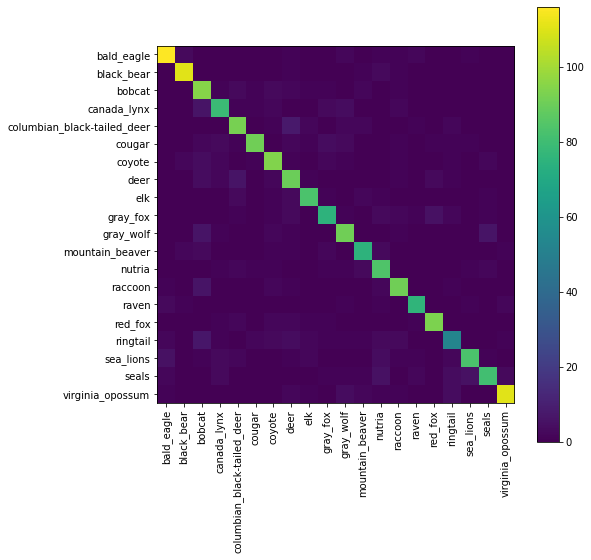

In [16]:
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_animals.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

# Algumas estatísticas (incompleto)

A ideia aqui é mostrar alguns limites usando recall e precisão.

Abaixo computo uma estatística de uma boa e ruim predição através da previsão da probabilidade máxima, probabilidade entre os dois melhores candidatos e o desvio.

Isso ajuda a mostrar a probabilidade do elemento (animal nesse caso) previsto ser muito baixa, então o desvio padrão é muito alto, ou a diferença entre os dois animais seja muito baixa.

In [41]:
y_pred = model.predict(X_test, verbose=0)
comp = np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1)
index_good, index_false = [i for i, x in enumerate(comp) if x], [i for i, x in enumerate(comp) if not x]

In [57]:
max_good = np.max(y_pred[index_good], axis=1)
max_wrong = np.max(y_pred[index_false], axis=1)
diff_good = np.diff(np.sort(y_pred[index_good], axis=1)[:, 16:])
diff_wrong = np.diff(np.sort(y_pred[index_false], axis=1)[:, 16:])
std_good = np.std(y_pred[index_good], axis=1)
std_wrong = np.std(y_pred[index_false], axis=1)

print("For good predictions : Max : {:.2f}, Difference Two First : {:.3f}, STD : {:.2f}".format(np.mean(max_good),
                                                                            np.mean(diff_good),
                                                                            np.mean(std_good)))
print("For wrong predictions : Max : {:.2f}, Difference Two First : {:.3f}, STD : {:.2f}".format(np.mean(max_wrong),
                                                                             np.mean(diff_wrong),
                                                                            np.mean(std_wrong)))

For good predictions : Max : 0.89, Difference Two First : 0.295, STD : 0.20
For wrong predictions : Max : 0.55, Difference Two First : 0.166, STD : 0.13


!TODO: gráficos scatter plot 

!TODO: recall e precisão em gráficos

# Visualizando a predição

Após obter os resultados acima, é possível testar de fato como o modelo vai predizer uma imagem, seja ela do dataset ou busca de outra fonte (que tenha relação com as classes claro).

Para isso foi criado alguns métodos:
- `url_to_image` vai pegar a url de uma imagem passada por parâmetro e transformar em uma imagem de fato.
- `map_percent_predict` usa a imagem criada para testar a predição da imagem, através da função `predict`.

In [33]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

# Este método usa `predict_proba` para retornar uma predição, 
# contudo, como ele me retorna de forma (1), 
# preferi usar apenas o `predict` que retorna as possibilidades
# entre 0..1 para aquela predição.

# def plot_and_predict(url, all_perc=False):
#     image = url_to_image(url)
#     img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.show()
#     pic = cv2.resize(img, (64,64))
#     a = model.predict_proba(pic.reshape(1, 64, 64,3))[0]
#     if all_perc:
#         print('\n'.join(['{} : {}%'.format(map_animals[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
#     else:
#         return map_animals[np.argmax(a)].replace('_',' ').title()

def map_percent_predict(url):
    
    F = plt.figure(1, (25,30))
    
    grid = AxesGrid(F, 111,  # similar to subplot(141)
        nrows_ncols=(1, 6),
        axes_pad=0,
        label_mode="1")
    
    it = 0

    # TODO: pensar em uma maneira melhor de montar esse loop
    for i in [0, 7, 8, 19, 5, 9]:
        char = map_animals[i] # busca a classe no dicionário
        
        image = url_to_image(url[it])
        
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pic = cv2.resize(img, (64, 64)).astype('float32') / 255. # normalização
        
        a = model.predict(pic.reshape(1, 64, 64, 3)) [0]

        actual = char.split('_')[0].title()
        
        text = sorted(['{:s} : {:.1f}%'.format(map_animals[k].split('_')[0].title(), 100*v) for k, v in enumerate(a)], 
            key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
        
        img = cv2.resize(img, (352, 352))
        cv2.rectangle(img, (0, 260), (215, 352), (255, 255, 255), -1)

        font = cv2.FONT_HERSHEY_SIMPLEX

        cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0, 0, 0), 2, cv2.LINE_AA)
        
        for k, t in enumerate(text):
            cv2.putText(img, t,(10, 300 + k*18), font, 0.65, (0, 0, 0), 2, cv2.LINE_AA)
        
        grid[it].imshow(img)            
        it += 1

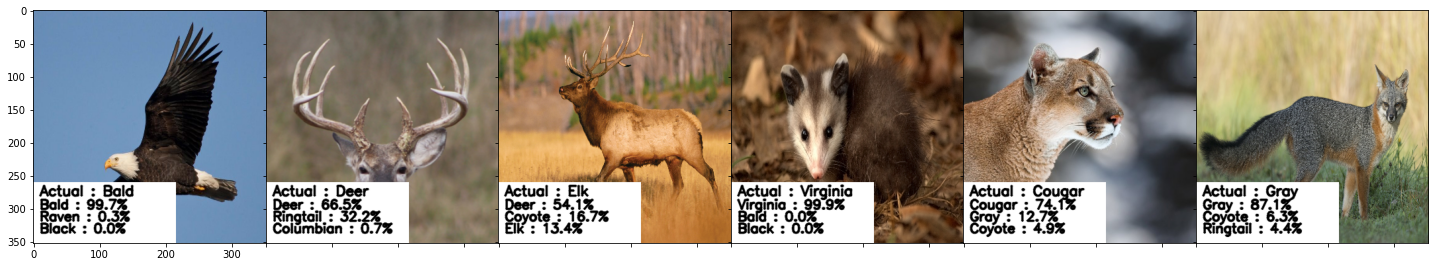

In [34]:
url = [
    "https://nature.mdc.mo.gov/sites/default/files/styles/centered_full/public/media/images/2013/11/bald_eagle_flying_11-20-13.jpg?itok=ZQZo0D-Q", #bald_eagle
    "https://tpwd.texas.gov/huntwild/wild/game_management/deer/images/WTD-Headshot.jpg", # deer
    "https://cdn.britannica.com/03/94603-050-D74D3709/elk-American-Yellowstone-National-Park-Wyoming.jpg", # elk
    "https://upload.wikimedia.org/wikipedia/commons/b/b7/Young_Virginia_Opossum.jpg", # virginia opossum
    "https://st2.depositphotos.com/3141125/6188/i/450/depositphotos_61883303-stock-photo-cougar-mountain-lion-puma-panther.jpg", #cougar
    "https://www.louisianafur.com/uploads/1/0/4/8/104800207/for-web-grey-fox-1-shutterstock_orig.jpg" #gray fox
] 
map_percent_predict(url)

# Considerações

A modelagem realizada ainda pode ser melhorada, provavelmente mudando os valores das camadas já existentes, ou até a adição de outros elementos como `Batch Normalization` que ajuda na diminuição de overfitting segundo algumas literaturas.

Outro fator de interesse pode ser a parte de `data augmentation` que pouco foi explorado, apenas realizado algumas mudanças.

Contudo, podemos ver que apesar dos valores resultantes, a rede já consegue realizar alguns algumas predições como esperado.

# Referências

[Don’t Use Dropout in Convolutional Networks](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html)

[Training Neural Networks, Part I](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture6.pdf)

[Dropout in (Deep) Machine learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)

[Improving Neural Networks with Dropout](http://www.cs.toronto.edu/~nitish/msc_thesis.pdf)
